# XGBoost Tunning


Load Libraries

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import xgboost as xgb
import seaborn as sns
import pandas as pd

from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split
from scipy import stats

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(font_scale = 1.5)

/Users/andrescala/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data and preprocess

In [3]:
data = pd.read_csv('data/cs-training.csv').drop('id', axis = 1).fillna(0)

target = data['SeriousDlqin2yrs'].astype('int')
data = data.drop(['SeriousDlqin2yrs'],axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
normalized_data = pd.DataFrame(x_scaled)
train_data, test_data, train_target, test_target  = train_test_split(normalized_data, target, test_size=0.3)

train_data.to_csv('gen_data/dataTrain.csv', sep=',', encoding='utf-8')
test_data.to_csv('gen_data/dataTest.csv', sep=',', encoding='utf-8')

print(train_data.shape)
print(train_target.shape)
print(test_data.shape)
print(test_target.shape)

(105000, 10)
(105000,)
(45000, 10)
(45000,)


# PCA

In [4]:
sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)

xScaled = sScaler.fit_transform(train_data)

forPca = pd.DataFrame(xScaled)

pca = PCA(n_components=2)

xPca = pca.fit_transform(train_data)

xPcaDataframe = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

xPcaDataframe['cat'] = train_target

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


explained variance ratio (first two components): [ 0.53373178  0.22190226]


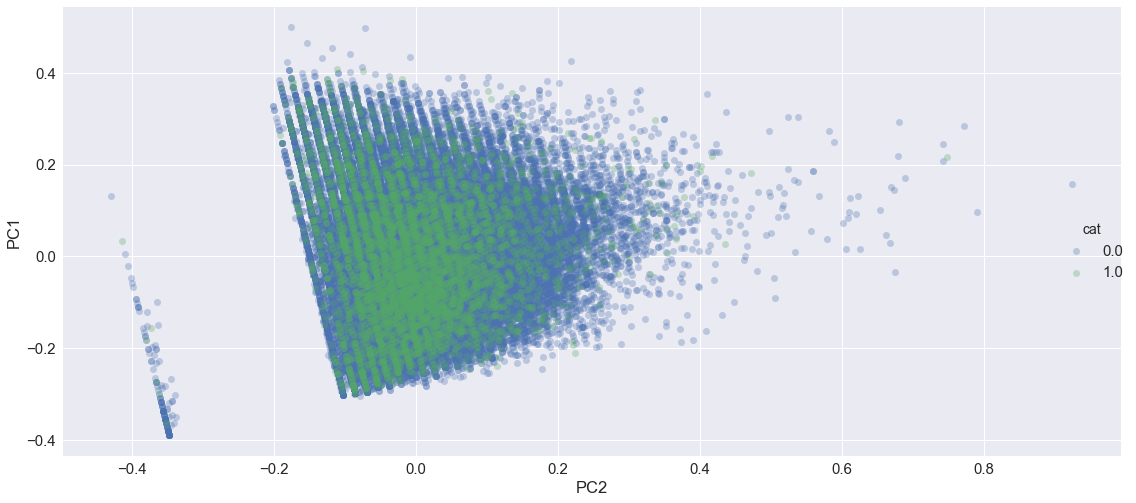

In [5]:
ax = sns.lmplot(data = xPcaDataframe, x='PC2', y='PC1', hue='cat', size=10, aspect=20, fit_reg=False,
               scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

### Converting data for XGBoost

In [6]:

#dataPredict = dataPredict.drop(['SeriousDlqin2yrs'],axis=1)

featNames = ['RevolvingUtilizationOfUnsecuredLines', 'age',
 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
xgtrain = xgb.DMatrix(train_data.values, label=train_target, feature_names=featNames )
xgtest = xgb.DMatrix(test_data.values, label=test_target, feature_names=featNames)
#xgpredict = xgb.DMatrix(dataPredict, label=None, feature_names=featNames)

In [7]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.4
}
params['eval_metric'] = ['error', 'auc']

num_rounds = 50

watchlist  = [(xgtest,'test'), (xgtrain,'train')] # native interface only
bst = xgb.train(params, xgtrain, num_rounds, watchlist, early_stopping_rounds=5)
print("Best train score: {}".format(bst.best_score))
print("Best iteration: {}".format(bst.best_iteration))
print("Best number of trees limit: {}".format(bst.best_ntree_limit))

[0]	test-error:0.064289	test-auc:0.812276	train-error:0.064324	train-auc:0.815714
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	test-error:0.063956	test-auc:0.831848	train-error:0.063562	train-auc:0.835017
[2]	test-error:0.063911	test-auc:0.837452	train-error:0.063857	train-auc:0.840741
[3]	test-error:0.063378	test-auc:0.839447	train-error:0.063238	train-auc:0.842659
[4]	test-error:0.063467	test-auc:0.840946	train-error:0.063276	train-auc:0.845598
[5]	test-error:0.063222	test-auc:0.841756	train-error:0.06319	train-auc:0.846167
[6]	test-error:0.063222	test-auc:0.842746	train-error:0.063114	train-auc:0.847816
[7]	test-error:0.062956	test-auc:0.846678	train-error:0.063095	train-auc:0.850874
[8]	test-error:0.062689	test-auc:0.851877	train-error:0.063	train-auc:0.855221
[9]	test-error:0.062578	test-auc:0.852973	train-error:0.063171	train-auc:0.856315
[10]	test-error:0.062622	test-auc:0.856216

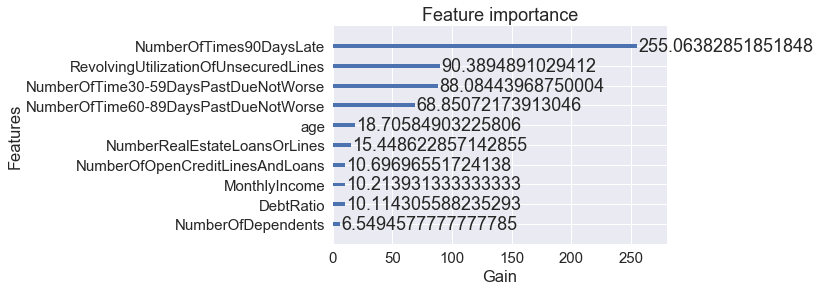

In [8]:
bst.save_model('featMap.txt')
trees_dump = bst.get_dump(fmap='featMap.txt', with_stats=True)
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')

In [9]:
seed = 10000
num_rounds = 10
params1 = {
    'objective':'binary:logistic',
    'max_depth':5,
    'silent':1,
    'eta':0.4
}
hist = xgb.cv(params1, xgtrain, num_rounds, nfold=10, metrics={'auc'}, seed=seed)
hist

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.843260,0.006514,0.845835,0.000912
1,0.848254,0.005594,0.850710,0.002035
2,0.850411,0.006579,0.852875,0.001243
3,0.850903,0.006725,0.853942,0.001307
4,0.853134,0.007123,0.857118,0.000916
5,0.854621,0.007182,0.858791,0.000994
6,0.855316,0.007535,0.860675,0.001395
7,0.857863,0.006709,0.864284,0.000916
8,0.859402,0.007193,0.866829,0.000748
9,0.860278,0.006783,0.868721,0.001012


In [10]:
y_test_preds = (bst.predict(xgb.DMatrix(test_data.values, feature_names=featNames)) > 0.5).astype('int')
pd.crosstab(
    pd.Series(test_target, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,12217,285,12502
1.0,881,19,900
All,13098,304,13402


In [11]:
print('Accuracy: {0:.2f}'.format(accuracy_score(test_target, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(test_target, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(test_target, y_test_preds)))

Accuracy: 0.94
Precision: 0.61
Recall: 0.20
